# 01-Maximum Likelihood Estimation (MLE)

본 포스트는 Rice University의 Richard W. Evans가 2018년 7월 QuantEcon에 게시한 [Maximum Likelihood Estimation](https://notes.quantecon.org/submission/5b3b102eb9eab00015b89f8e){: target="_blank"}을 기본적으로 번역하되, 필요에 따라 일부 내용을 수정하거나 추가적인 내용들을 덧붙이면서 만들어졌습니다.

<br>

## 1. Maximum Likelihood Estimation

MLE 추정법은 우리가 관측하는 데이터가 어떤 미지의 확률 분포를 따를 것이라는 강한 가정에 기초합니다. MLE의 목표는 데이터를 이용해서 바로 그 확률 분포가 어떻게 생겼을지 추론하는 데 있고, 이를테면 분포의 평균이나 분산과 같은 파라미터 $\theta$를 pin down합니다.

구체적인 추정 방식은 이름에서 알 수 있듯이 likelihood function $L(\theta)$를 극대화하는 $\hat \theta$를 찾도록 전개됩니다. Likelihood는 데이터가 관찰되었을 때 미지의 분포의 파라미터가 $\theta$일 가능성을 뜻하며, 달리 말하면 관측된 데이터가 특정 $\theta$에서 나왔을 확률입니다.

예를 들어 연속형 랜덤 변수 $X$가 $\theta$에 의존하는 $f$라는 PDF(probability density function)를 가진다면, $X=x$라는 하나의 값이 관찰될 때 다음과 같이 likelihood function을 정의할 수 있습니다. (이산형 랜덤 변수라면 probability mass function이겠고요.)

\begin{equation}
    L(\theta | x) = f(x | \theta)
\end{equation}

그리고 i.i.d인 관측치가 $(x_1, ..., x_N)$과 같이 $N$개라면 $L(\theta)$는 PDF의 곱으로 표현됩니다.

\begin{equation}
    L(\theta | x_1, ..., x_N) = \prod_{i=1}^{N} {f(x_i | \theta)}
\end{equation}

Log가 strictly increasing function이기 때문에 $L(\theta)$를 극대화하는 것과 $L(\theta)$를 log 변환한 log-likelihood function $l(\theta)$를 극대화하는 것은 동치입니다. $l(\theta)$는 아래와 같이 곱이 아닌 합으로 표현되겠습니다. ([Log-likelihood가 유리한 이유](https://stats.stackexchange.com/questions/70972/why-we-always-put-log-before-the-joint-pdf-when-we-use-mlemaximum-likelihood/70975#70975))

\begin{equation}
    l(\theta | x_1, ..., x_N) = \sum_{i=1}^{N} {\ln{f(x_i | \theta)}}
\end{equation}

$L(\theta)$나 $l(\theta)$를 극대화하는 $\theta$를 찾을 때 깔끔한 analytical solution이 있으면 좋겠지만, 없는 경우에는 Newton-Raphson algorithm과 같은 numerical method가 필요합니다.

우선 Normal 분포를 시작으로 analytical solution이 있는 경우를 살펴보도록 하겠습니다. Normal 분포에 대해 우리가 추정할 $\theta$는 
분포의 평균인 $\mu$와 분산 $\sigma^2$이고요, PDF는 다음과 같습니다.

$$\begin{equation}
    f(x_i | \mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}} \exp{\{ -\frac{(x_i-\mu)^2}{2\sigma^2} \}}
\end{equation}$$

앞서 정의한 대로 $N$개의 관측치에 대해 $l(\mu,\sigma^2)$은 다음과 같이 쓸 수 있습니다.

$$\begin{equation}
\begin{split}
    l(\mu,\sigma^2)
    &= \sum_{i=1}^{N}{ \ln{( \frac{1}{\sigma\sqrt{2\pi}} \exp{\{ -\frac{(x_i-\mu)^2}{2\sigma^2} \}} )} } \\
    &= -N \ln{\sigma} - \frac{N}{2} \ln{2\pi} - \frac{1}{2\sigma^2} \sum_{i=1}^{N}{(x_i-\mu)^2}
\end{split}
\end{equation}$$

이어서 $l(\mu,\sigma^2)$을 극대화하는 $\hat{\mu}$을 찾기 위해 아래와 같이 FOC를 구할 수 있습니다.

\begin{equation}
    \frac{\partial}{\partial\mu} l(\mu,\sigma^2) = \frac{1}{\sigma^2} \sum_{i=1}^{N}{(x_i-\mu)} = 0
\end{equation}

\begin{equation}
    \hat{\mu} = \frac{1}{N} \sum_{i=1}^{N}{x_i}
\end{equation}

같은 방식으로 $\hat{\sigma}^2$도 구할 수 있습니다.

\begin{equation}
    \frac{\partial}{\partial\sigma} l(\mu,\sigma^2) = - \frac{N}{\sigma} + \frac{1}{\sigma^3} \sum_{i=1}^{N}{(x_i-\mu)^2}
\end{equation}

\begin{equation}
    \hat{\sigma}^2 = \frac{1}{N} \sum_{i=1}^{N}{(x_i-\hat{\mu})^2}
\end{equation}

도출된 $\hat\mu$와 $\hat\sigma^2$이 likelihood function을 극대화하는 maximum likelihood estimator, 즉 우리가 알고 싶었던 Normal 분포의 파라미터 $\theta$를 추정하는 추정량 또는 공식이 되겠습니다.

<br>

## 2. Comparing Data and Distributions

실제 데이터를 가지고 likelihood를 계산하는 간단한 실습을 진행해 보겠습니다. 여기서 다룰 데이터는 원문 저자인 Richard의 거시경제학 과목에서 학생들이 득점한 성적입니다. 우선 실습에 필요한 라이브러리와 데이터를 불러옵니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sts
import scipy.optimize as opt

data = pd.read_csv("https://raw.githubusercontent.com/rickecon/Notebooks/master/MLE/data/Econ381totpts.txt",
                   header=None, names=["points"])
data

,points
0,275.50
1,351.50
2,346.25
3,228.25
4,108.25
...,...
156,235.00
157,102.20
158,112.30
159,130.60


히스토그램과 함께 임의의 Normal 분포 2개를 생성해 보겠습니다.

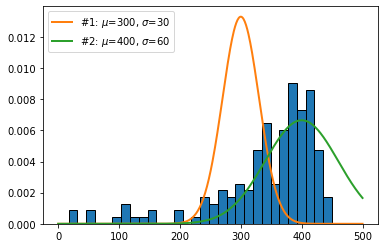

In [2]:
# 실제 관측된 히스토그램
plt.hist(data, bins=30, density=True, edgecolor='k')

# PDF 생성 함수
def norm_pdf(x_vals, mu, sigma):
    pdf_vals = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(- (x_vals-mu)**2 / (2*sigma**2))
    return pdf_vals

x_grid = np.linspace(0,500,500)

# Case 1
mu_1, sig_1 = 300, 30
plt.plot(x_grid, norm_pdf(x_grid, mu_1, sig_1),
         linewidth=2, label="#1: $\mu$=300, $\sigma$=30")

# Case 2
mu_2, sig_2 = 400, 60
plt.plot(x_grid, norm_pdf(x_grid, mu_2, sig_2),
         linewidth=2, label="#2: $\mu$=400, $\sigma$=60")

plt.legend()
plt.savefig("./assets/01-MLE/mle_01.png", dpi=200)

눈으로 보기에 두 번째 Normal 분포가 데이터를 더 잘 설명하는 듯 합니다.
수치적으로 확인하기 위해 각 분포에 대해서 log-likelihood를 계산해 보겠습니다.

In [3]:
def log_lik_norm(x_vals, mu, sigma):
    pdf_vals = norm_pdf(x_vals, mu, sigma)
    log_lik_val = np.log(pdf_vals).sum()
    return log_lik_val

print("Log-likelihood #1:", log_lik_norm(data.points, mu_1, sig_1))
print("Log-likelihood #2:", log_lik_norm(data.points, mu_2, sig_2))

Log-likelihood #1: -1552.8074968768929
Log-likelihood #2: -1057.641093120655


역시 $\mu$와 $\sigma$가 좀더 큰 두 번째 normal 분포에 대해서 log-likelihood가 더 크게 계산되었습니다.

<br>

## 3. Solving a Maximization (or Minimization) Problem

이제 scipy.optimize 패키지를 이용해서 solver를 통해 log-likelihood를 극대화하는 $\hat\mu$와 $\hat\sigma$를 찾아보겠습니다. 한 가지 짚고 넘어가면 likelihood는 무조건 [0,1] 사이의 값을 가지므로 위 두 경우에서 봤듯이 log-likelihood는 0일 때를 제외하고 항상 음수값을 가집니다. 따라서 likelihood 또는 log-likelihood를 maximize하는 문제는 negative log-likelihood를 minimize하는 문제와 동일합니다.

따라서 아래에서는 scipy.optimize 패키지에서도 minimze() 함수를 사용할 건데요. 첫 단계로 극소화하려는 목적함수, 즉 negative log-likelihood function을 objective라는 이름으로 생성하겠습니다. 위에서 정의했던 log_lik_norm()과 거의 동일한데, input을 받는 방식과 부호를 바꿔 음수를 반환하는 차이가 있습니다.

In [4]:
def objective(params, *args):
    mu, sigma = params
    x_vals = args
    
    log_lik_val = log_lik_norm(x_vals, mu, sigma)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

임의의 guess 값을 시작으로 목적함수 objective를 최적화하는 극솟값을 탐색합니다.

In [5]:
mu_init, sigma_init = 400, 60
params_init = (mu_init, sigma_init)

mle_args = data.points

mle_results = opt.minimize(objective, params_init, args=mle_args)
mle_results

      fun: 950.1687934479038
 hess_inv: array([[92.73681569, 17.66858475],
       [17.66858475, 24.95926171]])
      jac: array([7.62939453e-06, 7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 66
      nit: 18
     njev: 22
   status: 0
  success: True
        x: array([341.90864948,  88.47608833])

최적화가 잘 완료되었다는 메시지와 함께 마지막 줄에 $\hat\mu=341.91$과 $\hat\sigma=88.48$이 극솟값으로 pin down되었습니다.

첫 번째 섹션에서 수식으로 표현했던 analytical solution을 상기해서 비교해보아도 잘 추정된 것을 확인할 수 있습니다.

In [6]:
data.points.mean()

341.90869565217395

In [7]:
np.sqrt(1/len(data) * ((data.points - data.points.mean()) ** 2).sum())

88.47597014103917

Also see
- https://python.quantecon.org/mle.html